In [8]:
import sys

## !pip install -e ../gym_space_docking/

loc = os.popen('pip3 show gym_space_docking').readlines()[7].split()[1]


sys.path.append(loc)


import gym
import os
import gym_space_docking

In [9]:
# include Network
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
env = gym.make('space_docking-v0')
env.reset()

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [11]:
map, reward, done, info = env.step(0)
    

In [12]:
#map.reshape(88,80,3)

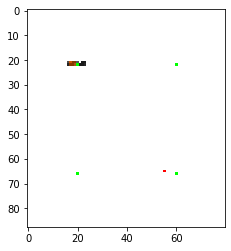

In [13]:
from matplotlib import pyplot as plt
plt.imshow(map, interpolation='nearest')
plt.show()

In [14]:
num_actions = env.action_space.n


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(88, 80, 3,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

In [15]:
model = keras.models.load_model('train_model')
model_target = keras.models.load_model('target_model')

In [16]:
#model = create_q_model()
#model_target = create_q_model()

#model.compile()
#model_target.compile()

In [17]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

In [18]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:  # Run until solved
    state = np.array(env.reset()[0])
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)


        #plt.imshow(state_next, interpolation='nearest')
        #plt.show()
        #print(reward)
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            #print(state_sample)
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )


            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            print(rewards_history[-1])
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if episode_count % 50 == 0:
        #print('save model')
        model.save('train_model')
        model_target.save('target_model')

    if running_reward > 10000000:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

-5.279999999999993
-3.1799999999999953
-6.139999999999939
-16.51999999999986
-3.2599999999999927
-15.699999999999749
-18.74000000000001
-2.6199999999999966
-39.35999999999981
-3.6599999999999744
38.8800000000006
-6.759999999999916
-15.75999999999988
-7.239999999999907
-19.45999999999986
-8.759999999999977
-24.840000000000376
-1.9399999999999968
-8.879999999999958
-1.4399999999999893
-1.399999999999995
-1.0799999999999947
-4.9999999999999485
-1.6000000000000012
-2.17999999999999
-29.72000000000095
-1.0200000000000007
running reward: 321.50 at episode 27, frame count 10000
-9.419999999999947
-6.419999999999977
-9.15999999999993
-24.119999999999838
-4.73999999999998
-20.780000000000342
55.30000000000112
-0.7200000000000004
-10.599999999999925
-2.4599999999999955
-0.9400000000000006
-1.1999999999999966
-8.379999999999875
-8.839999999999952
-21.180000000000334
-16.97999999999981
19.739999999998492
-30.119999999999877
-11.439999999999806
-1.2599999999999882
-6.359999999999944
running reward:

2022-01-26 11:20:47.872259: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: train_model/assets
INFO:tensorflow:Assets written to: target_model/assets
-12.559999999999889
-2.1399999999999983
-1.9200000000000006
-31.260000000000105
-2.59999999999998
63.600000000000854
-3.519999999999979
-1.3399999999999963
63.44000000000081
-48.87999999999961
-2.6999999999999913
-1.8400000000000005
-1.7000000000000004
-4.27999999999998
-23.87999999999989
-23.9400000000024
-6.799999999999958
-2.2199999999999855
-17.639999999999734
-8.9399999999999
-0.8200000000000005
running reward: 1079.30 at episode 71, frame count 30000
-31.260000000000467
-7.499999999999915
-18.04000000000068
-1.0000000000000007
-1.619999999999989
-4.439999999999989
-1.6000000000000012
-12.679999999999858
12.499999999999007
14.280000000000236
-4.0399999999999805
-0.5200000000000002
-5.259999999999928
48.72000000000116
-9.639999999999901
-1.8000000000000005
-3.0799999999999903
-10.559999999999949
-1.6199999999999983
-12.279999999999834
61.34000000000115
-8.69999999999994
-2.8